In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Adam
import torch.nn.functional as F

import csv
from skimage import io

from PIL import Image
import pandas as pd

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import time
import os
import copy

import sys
sys.path.append('JupyterProjects/EYE-SEA/DataSets/MARVEL_code')

import import_ipynb
#import Dataset_loader_MARVEL
import ResNetCaps
import Pets_Loader
import Animals_Loader

verbose = False
USE_CUDA = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CIFAR10_USE = True
MARVEL_USE = False
PETS_USE = False
Animals_USE = False

importing Jupyter notebook from ResNetCaps.ipynb
importing Jupyter notebook from Pets_Loader.ipynb
importing Jupyter notebook from Animals_Loader.ipynb


In [2]:
class MARVEL_dataset(Dataset):
    def __init__(self, dat_file,train = True, transform = None):   
        self.root_dir = os.path.dirname(dat_file)
        datContent = [i.strip().split(',') for i in open(dat_file).readlines()]
        if train:
            csv_file = os.path.join(self.root_dir, "data_Train.csv")
        else:
            csv_file = os.path.join(self.root_dir, "data_Test.csv")
        with open(csv_file, "w") as f:
            writer = csv.writer(f,delimiter=',')
            writer.writerow(["counter", "set", "class", "label","location"])
            for line in datContent:
                if train and line[1]=='1':
                    if not(line[4] == '-'):
                        writer.writerows([line])  
                if not(train) and line[1] == '2':
                    if not(line[4]=='-'):
                        writer.writerows([line]) 
                
        self.MARVEL_datafile = pd.read_csv(csv_file)       
        self.transform = transform
        
    def __len__(self):
        return len(self.MARVEL_datafile)
    
    def __getitem__(self,idx):
        img_name = self.MARVEL_datafile.iloc[idx,4]
        image = self.__loadfile(img_name)
        target = self.MARVEL_datafile.iloc[idx,2]
        if self.transform:
            image = Image.fromarray(image)
            sample = self.transform(image)
        else:
            sample = image
        return (sample,target)
    
    def __loadfile(self, data_file):
        image = io.imread(data_file)
        if len(image.shape)<3:
            image = np.stack((image,)*3, axis=-1)
        return image

In [3]:
dataset_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),        
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


batch_size = 32


if CIFAR10_USE: 
    NUM_CLASSES = 10
    print("CIFAR10")
    image_datasets = {'train': datasets.CIFAR10('../data', train=True, download=True, transform=dataset_transform),'val': datasets.CIFAR10('../data', train=False, download=True, transform=dataset_transform)}
    print("Initializing Datasets and Dataloaders...")

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True) , 'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True) }
    print("Initializing Datasets and Dataloaders...")

if MARVEL_USE: 
    NUM_CLASSES = 26
    print("MARVEL")
    dat_file = "/home/rita/JupyterProjects/EYE-SEA/DataSets/marveldataset2016-master/FINAL.dat"

    image_datasets = {'train': MARVEL_dataset(dat_file,train = True,transform=dataset_transform),'val': MARVEL_dataset(dat_file,train = False,transform=dataset_transform)}
    print("Initializing Datasets and Dataloaders...")

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True) , 'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True) }
    print("Initializing Datasets and Dataloaders...")
    
if  PETS_USE:
    NUM_CLASSES = 37
    print("PETS")
    dat_file = "/home/rita/JupyterProjects/EYE-SEA/DataSets/Pets/Pet_Datasets"

    image_datasets = {'train': Pets_Loader.PETS_dataset(dat_file,train = True,transform=dataset_transform),'val': Pets_Loader.PETS_dataset(dat_file,train = False,transform=dataset_transform)}
    print("Initializing Datasets and Dataloaders...")

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True) , 'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True) }
    print("Initializing Datasets and Dataloaders...")    
    
if  Animals_USE:
    NUM_CLASSES = 50
    print("Animals")
    dat_file = "/home/rita/JupyterProjects/EYE-SEA/DataSets/Animals_with_Attributes2/JPEGImages"

    image_datasets = {'train': Animals_Loader.Animals_dataset(dat_file,train = True,transform=dataset_transform),'val': Animals_Loader.Animals_dataset(dat_file,train = False,transform=dataset_transform)}
    print("Initializing Datasets and Dataloaders...")

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True) , 'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True) }
    print("Initializing Datasets and Dataloaders...")    

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Initializing Datasets and Dataloaders...
Initializing Datasets and Dataloaders...


In [4]:
def shift_left_once(A):
    a =  []
    AD = A.detach().cpu().numpy()
    temp = AD[0,:]

    for index in range(1,len(AD)):
        a = np.concatenate([a,AD[index]])
    a = np.concatenate([a,temp])
    a_tensor = torch.from_numpy(a)
    return ((a_tensor.view(len(a),1)).float()).to(device)

def shift_left(lst, n):
    assert (n >= 0), "n should be non-negative integer"
    for _ in range(n):
        shift_left_once(lst)

def circulant(A):
    r = A.size()[0]
    circ_list_a = []
    circ_list_a.append(A)
    
    a = shift_left_once(A)
    for i in range(r-1):   
        circ_list_a.append(a)      
        a = shift_left_once(a)

    
    circ = torch.cat(circ_list_a,0).detach().requires_grad_()
    circ = circ.view([r,r])
    if verbose: print("circular matrix {}".format(circ))
    return circ.to(device)
        
        
    

In [5]:
class Interaction(nn.Module):
    def __init__(self,NUM_CLASSES):
        super(Interaction, self).__init__()
        self.modelCaps1 = ResNetCaps.ResNetCaps(NUM_CLASSES)
        self.modelCaps2 = ResNetCaps.ResNetCaps(NUM_CLASSES)
        
        self.W1 = torch.randn(NUM_CLASSES,NUM_CLASSES)
        self.W1.requires_grad = True
        
        self.W2 = torch.randn(NUM_CLASSES,NUM_CLASSES)
        self.W2.requires_grad = True
        
        self.modelLin = nn.Linear(NUM_CLASSES, NUM_CLASSES)
        self.NClass = NUM_CLASSES

    def cuda(self, device=None):
        self = super().cuda(device)
        self.W1 = self.W1.cuda(device)
        self.W2 = self.W2.cuda(device)
        return self 
        
    def forward(self,inputs):
        digit1,_ = self.modelCaps1(inputs)
        digit2,_ = self.modelCaps2(inputs)
        
        output = self.modelLin(self.interaction(digit1,digit2))
        return output
        
    def interaction(self,x,y):
        
        self.x = x
        self.y = y
         
        Z_list = []
        labels_size = x.size()[1]
        batch = min(x.size()[0],batch_size)
        for i in range(batch):
        
            xi = torch.sum(x[i,:,:,0],dim=1)
            yi = torch.sum(y[i,:,:,0],dim=1)
            
            xi = xi.view(self.NClass,1)
            yi = yi.view(self.NClass,1)

            V = torch.mm(self.W1,xi)   #< questo fa batch-matrix con matrix ?
            C = torch.mm(self.W2,yi)

            #CIRCOLANTE
            A = circulant(V)
            B = circulant(C)

            #INTERACTION MOMENT
            F = torch.mm(B,V)
            G = torch.mm(A,C)
            
            M = torch.add(F,G)

            Z_list.append(M)
            
        Z = torch.cat(Z_list,0)
        if verbose : print(Z.size())
        Z = Z.view(batch,labels_size)
        
        return Z   
        
    

In [6]:
def lr_decrease(optimizer, lr_clip):  
    for param_group in optimizer.param_groups:
        init_lr = param_group['lr'] 
        param_group['lr'] = init_lr*lr_clip
        
def isnan(x):
    return x != x        


In [7]:
lr = 0.001
threshold = 30
lr_clip = 0.01

In [9]:
model = Interaction(NUM_CLASSES)
#model = model.to(device)
model = model.cuda(device)

#optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = lr)
n_epochs = 10
#train
start = time.time()
#batch_id = 100
#inputs, labels = next(iter(dataloaders['train']))
accuracy_train = []
loss_train = []


for epoch in range(n_epochs): 
    model.train() 
    train_loss = 0
    train_accuracy = 0

    print('epoch {}:{}'.format(epoch+1, n_epochs)) 
    for batch_id, (inputs, labels) in enumerate(dataloaders['train']):
        if MARVEL_USE: labels = labels-1
        labels =torch.eye(NUM_CLASSES).index_select(dim=0, index=labels)
        inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _,label = torch.max(labels, 1)

        loss = criterion(outputs, label.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        train_accuracy += (sum(np.argmax(outputs.data.cpu().numpy(), 1) == np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))

        if batch_id % 100 == 0:
            print("train accuracy:", sum(np.argmax(outputs.data.cpu().numpy(), 1) == 
                                   np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
            print("loss : {}",format(loss.data[0]))
            if verbose: print("masked {}".format(np.argmax(masked.data.cpu().numpy(), 1)))
            if verbose: print("labels {}".format(np.argmax(labels.data.cpu().numpy(), 1)))
        #                batch_accuracy.append(sum(np.argmax(preds.data.cpu().numpy(), 1) == 
        #                                       np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
    accuracy_train.append(train_accuracy/len(dataloaders['train']))
    loss_train.append(train_loss/len(dataloaders['train']))
    
    if epoch>2:
        if accuracy_train[-1]<(accuracy_train[-2]*0.5):
            print("Learnining rate decrease")
            lr_decrease(optimizer,lr_clip)
    if epoch == threshold:
        print("Learnining rate decrease")
        lr_decrease(optimizer, lr_clip)

end = time.time()
print("Training time execution {}".format(end-start))
print("Loss value for training phase: {}".format(train_loss / len(dataloaders['train'])))
print("Accuracy value for training phase: {}".format(train_accuracy / len(dataloaders['train'])))

epoch 1:10


ResNetCaps.ipynb:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  "from torch.autograd import Variable\n",
ResNetCaps.ipynb:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  "USE_CUDA = True\n",
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train accuracy: 0.03125
loss : {} 2.2873988151550293
train accuracy: 0.09375
loss : {} 2.3072400093078613
train accuracy: 0.15625
loss : {} 2.0171470642089844
train accuracy: 0.3125
loss : {} 1.7666115760803223
train accuracy: 0.4375
loss : {} 1.462256908416748
train accuracy: 0.46875
loss : {} 1.441605567932129
train accuracy: 0.71875
loss : {} 1.0229971408843994
train accuracy: 0.46875
loss : {} 1.624979019165039
train accuracy: 0.46875
loss : {} 1.2594122886657715
train accuracy: 0.46875
loss : {} 1.4174882173538208
train accuracy: 0.65625
loss : {} 0.8656806349754333
train accuracy: 0.53125
loss : {} 1.1029000282287598
train accuracy: 0.71875
loss : {} 0.8873865604400635
train accuracy: 0.71875
loss : {} 0.7125087380409241
train accuracy: 0.65625
loss : {} 1.1779483556747437
train accuracy: 0.625
loss : {} 1.1438820362091064
epoch 2:10
train accuracy: 0.71875
loss : {} 0.8594723343849182
train accuracy: 0.875
loss : {} 0.602633535861969
train accuracy: 0.6875
loss : {} 0.9364101886

train accuracy: 0.875
loss : {} 0.4315178096294403
train accuracy: 1.0
loss : {} 0.026598259806632996
train accuracy: 0.9375
loss : {} 0.3104443848133087
train accuracy: 0.90625
loss : {} 0.23305141925811768
train accuracy: 0.9375
loss : {} 0.1816454529762268
train accuracy: 1.0
loss : {} 0.04419343173503876
Training time execution 5643.683134555817
Loss value for training phase: 0.13625019788742065
Accuracy value for training phase: 0.9527351247600768


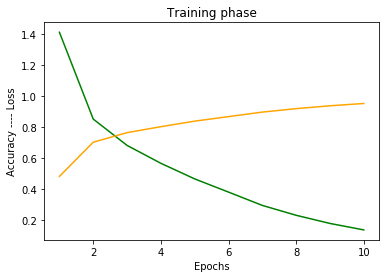

In [10]:
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs, loss_train, color='g')
plt.plot(epochs, accuracy_train, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy ---- Loss')
plt.title('Training phase')
plt.show() 

In [11]:
model.eval()
test_loss = 0
test_accuracy = 0 
start = time.time()
for batch_id, (inputs, labels) in enumerate(dataloaders['val']):
    if MARVEL_USE: labels = labels-1

    labels = torch.eye(NUM_CLASSES).index_select(dim=0, index=labels)
    inputs, labels = Variable(inputs), Variable(labels)

    if USE_CUDA: inputs, labels = inputs.to(device), labels.to(device)#cuda()

    outputs = model(inputs)
    _,label = torch.max(labels, 1)
    loss = criterion(outputs, label.long())

    test_loss += loss.data[0]
    test_accuracy += (sum(np.argmax(outputs.data.cpu().numpy(), 1) == np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))

    if batch_id % 100 == 0:
        print("test accuracy:", sum(np.argmax(outputs.data.cpu().numpy(), 1) == 
                               np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
end = time.time()
print("Test time execution {}".format(end-start))
print("Loss value for test phase: {}".format(test_loss /  len(dataloaders['val']))) 
print("Accuracy value for test phase: {}".format(test_accuracy / len(dataloaders['val'])))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


test accuracy: 0.84375
test accuracy: 0.8125
test accuracy: 0.75
test accuracy: 0.8125
Test time execution 74.83174657821655
Loss value for test phase: 0.8806149959564209
Accuracy value for test phase: 0.7848442492012779


In [ ]:
torch.cuda.empty_cache()